In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# Use the GPU
if torch.backends.mps.is_available():
    print("MPS device is available.")
    device = torch.device("mps")
elif torch.cuda.is_available():
    print("CUDA device is available.")
    device = torch.device("cuda")
else:
    print("No GPU acceleration available.")
    device = torch.device("cpu")

# Fix the seed to have deterministic behaviour
def fix_random(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

SEED = 1337
fix_random(SEED)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

DATASET_PATH = "dataset_train/dataset.csv"
dataset = pd.read_csv(DATASET_PATH, delimiter=",")

print(f"Shape of the dataset: {dataset.shape}")
duplicates = dataset[dataset.duplicated()]
print(f"Number of duplicates in the dataset: {duplicates.shape[0]}")

MPS device is available.
Shape of the dataset: (148301, 145)
Number of duplicates in the dataset: 0


Text(0.5, 0, 'Credit Risk Grade')

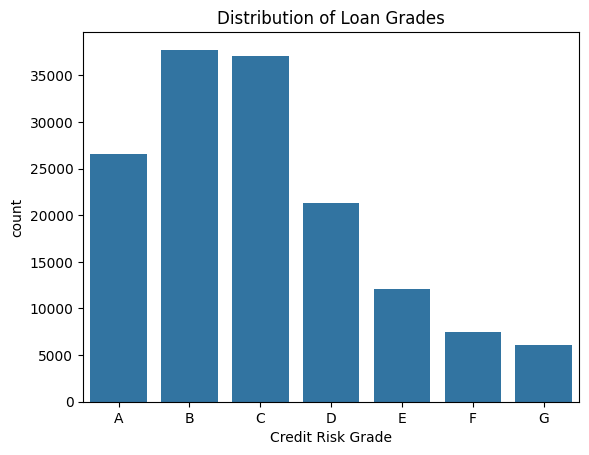

In [3]:
# Get the different types of credit risk, and its distribution
grade_types = sorted(dataset['grade'].unique())

sns.countplot(data=dataset, x='grade', order=grade_types)
plt.title('Distribution of Loan Grades')
plt.xlabel('Credit Risk Grade')

## Handling NaNs
We drop columns with more than 20% of NaNs. We go from 145 to 89 features

original_projected_additional_accrued_interest       99.564399
hardship_loan_status_label                           99.432910
hardship_type_label                                  99.431561
hardship_end_date                                    99.431561
hardship_duration_days                               99.430887
hardship_last_payment_amount_total                   99.430887
hardship_days_past_due                               99.430887
hardship_reason_label                                99.430213
hardship_start_date                                  99.429539
hardship_payment_plan_start_date                     99.429539
hardship_deferral_term_months                        99.428864
hardship_status_label                                99.428190
hardship_amount_total                                99.428190
hardship_payoff_balance                              99.427516
secondary_applicant_months_since_last_major_derog    98.374927
settlement_term_months                               98

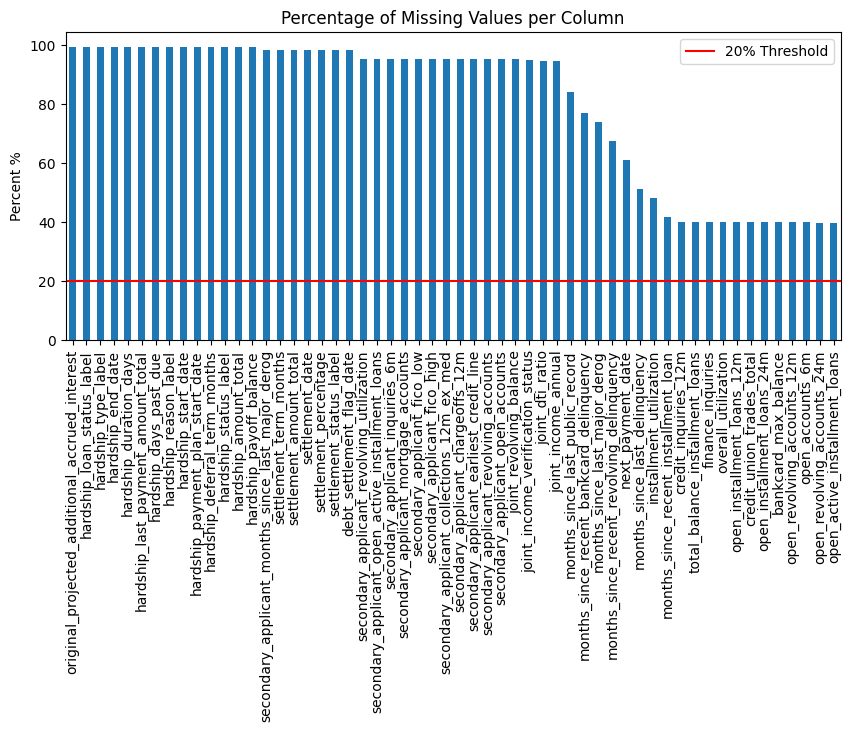

Shape before dropping columns: (148301, 145)
Shape after dropping columns: (148301, 88)


In [4]:
COLUMNS_TO_DROP_PERCENT = 20 # WHAT IF I PUT 50 INSTEAD?

# Show the percentage of missing values
missing_percentages = dataset.isna().mean() * 100
cols_to_drop = missing_percentages[missing_percentages > COLUMNS_TO_DROP_PERCENT]
print(cols_to_drop.sort_values(ascending=False))

plt.figure(figsize=(10, 4))
cols_to_drop.sort_values(ascending=False).plot(kind='bar')
plt.title('Percentage of Missing Values per Column')
plt.ylabel('Percent %')
plt.axhline(y=COLUMNS_TO_DROP_PERCENT, color='r', linestyle='-', label=f'{COLUMNS_TO_DROP_PERCENT}% Threshold')
plt.legend()
plt.show()

# drop columns with more than 20% of NaNs. We go from 145 to 89 features
print(f"Shape before dropping columns: {dataset.shape}")
dataset.drop(columns=cols_to_drop.index, inplace=True)
# Drop also loan_title since it's redundant with loan_purpose_category
dataset.drop(columns="loan_title", inplace=True)
print(f"Shape after dropping columns: {dataset.shape}")

## Categorical data conversion and dataset splitting

In [5]:
numerical_cols = dataset.select_dtypes(include=['number']).columns
print("Before converting categorical data")
categorical_cols = dataset.select_dtypes(include=['object', 'category']).columns
print(f"Categorical columns:\n{categorical_cols}")

Before converting categorical data
Categorical columns:
Index(['loan_contract_term_months', 'borrower_profile_employment_length',
       'borrower_housing_ownership_status',
       'borrower_income_verification_status', 'loan_issue_date',
       'loan_status_current_code', 'loan_payment_plan_flag',
       'loan_purpose_category', 'borrower_address_zip',
       'borrower_address_state', 'credit_history_earliest_line',
       'listing_initial_status', 'last_payment_date', 'last_credit_pull_date',
       'application_type_label', 'hardship_flag_indicator',
       'disbursement_method_type', 'debt_settlement_flag_indicator', 'grade'],
      dtype='object')


### Stateless categorical data conversion

In [6]:
# Stateless transformations (can be done on train and test set independently)
dataset["grade"] = dataset["grade"].map({'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0})

def extract_int_value_from_column(column_name):
    dataset[column_name] = dataset[column_name].str.extract(r"(\d+)").astype("Int64")

extract_int_value_from_column("loan_contract_term_months")
extract_int_value_from_column("borrower_profile_employment_length")

# DROP FOR TREES, USE FOR DEEP ENTWORKS
# extract_int_value_from_column("borrower_address_zip")
dataset.drop(columns="borrower_address_zip", inplace=True)

def convert_mm_yyyy_to_year_sine_cosine(column_name):
    # Convert mm-yyyy to the year and month encoded in sine/cosine representation so that dec 1999 and jan 2000 are close
    dataset[column_name] = pd.to_datetime(dataset[column_name], format='%b-%Y')
    date_col = dataset[column_name].dt # avoid creating temporary object
    dataset[f"{column_name}_year"] = date_col.year
    angle = 2 * np.pi * date_col.month / 12
    dataset[f"{column_name}_month_sin"] = np.sin(angle)
    dataset[f"{column_name}_month_cos"] = np.cos(angle)
    dataset.drop(columns=[column_name], inplace=True)

convert_mm_yyyy_to_year_sine_cosine("loan_issue_date")
convert_mm_yyyy_to_year_sine_cosine("credit_history_earliest_line")
convert_mm_yyyy_to_year_sine_cosine("last_payment_date")
convert_mm_yyyy_to_year_sine_cosine("last_credit_pull_date")

### Splitting the dataset

In [7]:
X = dataset.drop(columns=["grade"])
y = dataset["grade"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

print("Training set")
print(X_train.shape)
print(y_train.shape)

print("Validation set")
print(X_val.shape)
print(y_val.shape)

Training set
(118640, 94)
(118640,)
Validation set
(29661, 94)
(29661,)


### Stateful categorical data conversion

In [8]:
# Stateful transformations (with statistics calculated on training set and applied on both sets)

# We transform the binary categorical cols with 1 and 0. We use 1 for the least frequent data
# because it carries more signal
binary_categorical_cols = ["loan_payment_plan_flag", "listing_initial_status", "application_type_label",
               "hardship_flag_indicator", "disbursement_method_type", "debt_settlement_flag_indicator"]
binary_categorical_cols_feature_map = {}

# FIT: Calculate mode only on X_train
# TRANSFORM: Apply to X_train and x_val using the mode of X_train
for col in binary_categorical_cols:
    col_mode = X_train[col].mode()[0]
    binary_categorical_cols_feature_map[col] = col_mode
    X_train[col] = (X_train[col] != col_mode).astype("Int64")
    X_val[col] = (X_val[col] != col_mode).astype("Int64")


one_hot_encoding_cols = ["borrower_housing_ownership_status", "borrower_income_verification_status",
                       "loan_status_current_code", "loan_purpose_category", "borrower_address_state"]

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[one_hot_encoding_cols])
one_hot_encoding_feature_names = encoder.get_feature_names_out(one_hot_encoding_cols)

# Apply one-hot encoding to the training set
X_train_encoded = pd.DataFrame(encoder.transform(X_train[one_hot_encoding_cols]), columns=one_hot_encoding_feature_names, index=X_train.index)
X_train = pd.concat([X_train.drop(columns=one_hot_encoding_cols), X_train_encoded], axis=1)

# Apply one-hot encoding to the test set
X_val_encoded = pd.DataFrame(encoder.transform(X_val[one_hot_encoding_cols]), columns=one_hot_encoding_feature_names, index=X_val.index)
X_val = pd.concat([X_val.drop(columns=one_hot_encoding_cols), X_val_encoded], axis=1)

In [9]:
# print(X_train["borrower_address_zip"].nunique())

In [10]:
# print(X_train["borrower_address_zip"].unique())

In [11]:
print("After converting categorical data")
print(f"Train Shape: {X_train.shape}")
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
print(f"Categorical columns:\n{categorical_cols}")
print(f"Test Shape:  {X_val.shape}")
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
print(f"Categorical columns:\n{categorical_cols}")

After converting categorical data
Train Shape: (118640, 172)
Categorical columns:
Index([], dtype='object')
Test Shape:  (29661, 172)
Categorical columns:
Index([], dtype='object')


In [12]:
# Assume X_train is your processed numeric dataframe
# Calculate the correlation matrix
corr_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
# (Because the matrix is symmetrical, we only need to check one half)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Dropping {len(to_drop)} columns that are redundant: {to_drop}")

# Drop them
X_train_reduced = X_train.drop(columns=to_drop)
X_val_reduced = X_val.drop(columns=to_drop)

Dropping 9 columns that are redundant: ['loan_portfolio_total_funded', 'investor_side_funded_amount', 'outstanding_principal_investor_side', 'total_payment_investor_side', 'total_received_principal', 'collection_recovery_fee', 'revolving_tradelines_balance_gt_0', 'satisfactory_accounts', 'total_high_credit_limit']


In [ ]:
print(corr_matrix.shape)

In [279]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

pipeline = Pipeline([
    # ('imputer', SimpleImputer(strategy='median')), # 1. Fix missing values
    # ('pca', PCA(n_components=0.95)),
    ('rf', RandomForestClassifier(max_depth=50, class_weight='balanced', n_jobs=-1))
])

# clf = RandomForestClassifier(max_depth=50, class_weight='balanced', n_jobs=-1)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_val)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc}")
bacc = balanced_accuracy_score(y_val, y_pred)
print(f"Balanced accuracy: {bacc}")
f1 = f1_score(y_val, y_pred, average="weighted")
print(f"F1 score: {f1}")
    

Accuracy: 0.8717844981625704
Balanced accuracy: 0.8144404191649454
F1 score: 0.8700756492109305


In [280]:
print("Before dropping")
print(X_train.shape)
print(X_val.shape)

X_train.dropna(inplace=True)
y_train = y_train.loc[X_train.index]

X_val.dropna(inplace=True)
y_val = y_val.loc[X_val.index]

print("After dropping")
print(X_train.shape)
print(X_val.shape)

Before dropping
(118640, 172)
(29661, 172)
After dropping
(55074, 172)
(13629, 172)


Original train shape: (55074,)
Resampled train shape: (16653,)
(16653,)


/var/folders/1b/5t27cfwx5ys8870_bck3jc840000gn/T/ipykernel_76622/4015135619.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_undersampled, palette="viridis")


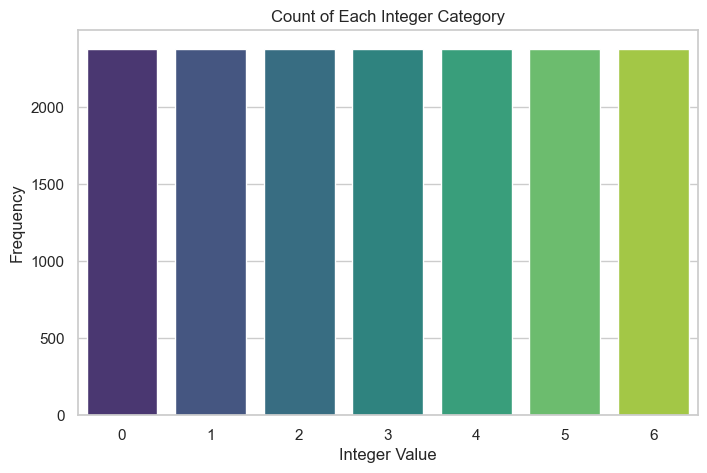

In [281]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

print(f"Original train shape: {y_train.shape}")

X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train.values, y_train.values)

print(f"Resampled train shape: {y_train_undersampled.shape}")

print(y_train_undersampled.shape)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train_undersampled, palette="viridis")
plt.title('Count of Each Integer Category')
plt.xlabel('Integer Value')
plt.ylabel('Frequency')
plt.show()

In [282]:
# WORKS WORSE THAN RANDOM UNDERSAMPLING

# from imblearn.over_sampling import SMOTE

# X_train_f = X_train.astype(float)
# y_train_f = y_train.astype(float)

# sm = SMOTE(random_state=42)

# print(f"Original train shape: {y_train.shape}")

# # 2. Fit and Resample
# # SMOTE creates synthetic points for the minority class
# X_train_res, y_train_res = sm.fit_resample(X_train_f, y_train_f)

# print(f"Resampled train shape: {y_train.shape}")

# # 3. Visualize the new balance
# sns.set_theme(style="whitegrid")
# plt.figure(figsize=(8, 5))
# sns.countplot(x=y_train_res, palette="viridis")
# plt.title('Balanced Class Distribution (After SMOTE)')
# plt.xlabel('Category')
# plt.ylabel('Frequency')
# plt.show()

In [283]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # 1. Fix missing values
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),              # 3. Reduce noise/dimensions
    ('knn', KNeighborsClassifier(n_neighbors=16, weights='distance'))
])

# balanced accuracy is better with undersampling
pipeline.fit(X_train_undersampled, y_train_undersampled)
# pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc}")
bacc = balanced_accuracy_score(y_val, y_pred)
print(f"Balanced accuracy: {bacc}")
f1 = f1_score(y_val, y_pred, average="weighted")
print(f"F1 score: {f1}")


/Users/geko/unibo/data_analytics/project/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


Accuracy: 0.31704453738352045
Balanced accuracy: 0.31042868980621313
F1 score: 0.3139805929826103


# ---------------------------

## Handling the remaining columns

We don't know if the column `months_since_recent_inquiry` with a NaN means that the person never had an inquiry or the value is missing for another reason.
The strategy is:

- for linear models: we fill in mean/median based on the distribution
- for tree models: we use an extreme number (np.max) to introduce a clear separation
- for deep learning models: create a column `never_had_inquiry` to set to 1 where we have a NaN.

In [284]:
print(X_train.shape)
list(dataset)

(55074, 172)


['loan_contract_approved_amount',
 'loan_portfolio_total_funded',
 'investor_side_funded_amount',
 'loan_contract_term_months',
 'loan_contract_interest_rate',
 'loan_payment_installments_count',
 'borrower_profile_employment_length',
 'borrower_housing_ownership_status',
 'borrower_income_annual',
 'borrower_income_verification_status',
 'loan_status_current_code',
 'loan_payment_plan_flag',
 'loan_purpose_category',
 'borrower_address_state',
 'borrower_dti_ratio',
 'credit_delinquencies_2yrs',
 'fico_score_low_bound',
 'fico_score_high_bound',
 'credit_inquiries_6m',
 'credit_open_accounts',
 'credit_public_records',
 'revolving_balance',
 'revolving_utilization',
 'credit_total_accounts',
 'listing_initial_status',
 'outstanding_principal_balance',
 'outstanding_principal_investor_side',
 'total_payment_received',
 'total_payment_investor_side',
 'total_received_principal',
 'total_received_interest',
 'total_received_late_fees',
 'recoveries_cash',
 'collection_recovery_fee',
 'la